In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import datasets 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
RSEED = 1234
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

#  סעיף 1 : טעינת הנתונים

In [3]:
knesset21 = pd.read_csv('C:\\Users\\HP\\Downloads\\votes21.csv', encoding="ISO-8859-8")
knesset22 = pd.read_csv('C:\\Users\\HP\\Downloads\\votes22.csv', encoding="ISO-8859-8")
knesset23 = pd.read_csv('C:\\Users\\HP\\Downloads\\votes23.csv', encoding="ISO-8859-8")
cities = pd.read_excel('C:\\Users\\HP\\Desktop\\cities.xlsx',converters={'קואורדינטות':str})

# change names of columns to avoid bugs when summing two columns later
knesset21.rename(columns ={'אמת':'_אמת', 'מחל':'_מחל' ,'טב':'_טב'}, inplace=True)
knesset22.rename(columns = {'אמת':'_אמת', 'מחל':'_מחל' ,'טב':'_טב'}, inplace=True)



## בדיקת תקינות הטעינה: מספר הרשומות בכל קובץ

In [4]:
print([len(a.index) for a in (knesset21,knesset22, knesset23, cities)])

[1214, 1214, 1214, 1482]


## השוואת העמודות: אילו שמות של רשימות אינן משותפות


היו שינויים ברשימות בין מערכות בחירות

אנחנו ננסה לייצג את התוצאות ע"י איחוד של רשימות בבחירות ה21 וה22 אם הם התאחדו בבחירות ה
23


In [5]:
cols21, cols22, cols23 = [set(a.columns) for a in (knesset21, knesset22, knesset23)]
print('in k21 but not 22:', cols21 - cols22)
print('in k22 but not 21:',cols22- cols21)

print('in k23 but not 21:', cols23 - cols21)

print('in all:', cols21 & cols22 & cols23)

cols_all = [c for c in knesset23.columns if c in cols21 & cols22 & cols23]
print(cols_all)

in k21 but not 22: {'קף', 'ן', 'צק', 'יץ', 'דעם', 'ןך', 'קן', 'ךק', 'זנ', 'ץז', 'נז', 'ןנ', 'קי', 'ףץ', 'זי', 'ףנ', 'ין', 'ר', 'ום', 'ףך', 'זך', 'נר', 'ףי', 'ץי'}
in k22 but not 21: {'זן', 'קך', 'צן', 'קץ', 'סמל ועדה', 'כי', 'יף', 'צ', 'כף', 'יק', 'רק', 'ודעם', 'זכ', 'ינ'}
in k23 but not 21: {'טב', 'קך', 'נק', 'כן', 'קץ', 'סמל ועדה', 'מחל', 'ני', 'יף', 'Unnamed: 37', 'יק', 'ודעם', 'אמת', 'יר', 'ינ'}
in all: {'פה', 'זץ', 'כשרים', 'בזב', 'י', 'כ', 'סמל ישוב', 'ל', 'נץ', 'פסולים', 'שם ישוב', 'ז', 'ףז', 'ק', 'מצביעים', 'יז', 'נ', 'שס', 'ץ', 'ג'}
['שם ישוב', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים', 'ג', 'ז', 'זץ', 'י', 'יז', 'כ', 'ל', 'נ', 'נץ', 'פה', 'ףז', 'ץ', 'ק', 'שס']



## עקרונות לאיחוד הקבצים
1. הפתקים של מרצ ואמת יאוחדו ברשימות של כנסת 21 22
1. הפתקים ום, דעם יאוחדו ברשימות של כנסת 21
1. הפתקים נ,טב יאוחדו ברשימות של כנסת 21
1. הפתקים כ,מחל יאוחדו ברשימות של 21
1. הפתקים כף,טב יאוחדו ברשימות של 22
1. הפתקים של כל המפלגות שלא עברו את אחוז החסימה יאוחדו ל"השאר"

## combine the 3 results into a single dataframe

In [6]:
cols = ['knesset',
    'שם ישוב', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים', 
        'אמת', 'ג', 'ודעם', 'טב', 
         'ל', 'מחל', 'פה', 'שס']

parties = cols[-8:]

knesset21['אמת']  = knesset21['_אמת'] + knesset21['מרצ']
knesset21['ודעם']  = knesset21['ום'] + knesset21['דעם']
knesset21['טב']  = knesset21['_טב'] + knesset21['נ']
knesset21['מחל']  = knesset21['_מחל'] + knesset21['כ']

knesset22['טב'] = knesset22['_טב']
knesset22['אמת']  = knesset22['_אמת'] + knesset22['מרצ']

knesset22['מחל']  = knesset22['_מחל'] + knesset22['כ']


knesset21['knesset'] = 21
knesset22['knesset'] = 22
knesset23['knesset'] = 23


knesset = pd.DataFrame(columns = cols)
knesset = knesset.append(knesset21[cols]).append(knesset22[cols]).append(knesset23[cols])

print(knesset.columns)
print(len(knesset.index))

Index(['knesset', 'שם ישוב', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים',
       'אמת', 'ג', 'ודעם', 'טב', 'ל', 'מחל', 'פה', 'שס'],
      dtype='object')
3642


In [7]:
parties

['אמת', 'ג', 'ודעם', 'טב', 'ל', 'מחל', 'פה', 'שס']

### add columns for political blocs

למרות האיחוד מספר המפלגות עדיין גדול ואם ננסה לצייר גרפים הם יצאו מפורטים מדי ולכן מבלבלים.

לכן נצמצם ל-3 גושים פעילים בלבד

ועוד קטגוריה "אחרים" למפלגות שלא עברו את אחוז החסימה



In [8]:
# הוספת עמודות לגושים פוליטיים
knesset['bloc_right'] = knesset[['מחל','שס','ג','טב']].sum(axis=1)
knesset['bloc_center'] = knesset[['פה','ל']].sum(axis=1)
knesset['bloc_left'] = knesset[['ודעם','אמת']].sum(axis=1)
knesset['bloc_rest'] = knesset['כשרים'] - knesset[parties].sum(axis=1)

## סעיף 2 : טבלאות + גרפים

### סיכום תוצאות ברמה הארצית לפי מפלגות - טבלה

In [9]:
israel_total = knesset.groupby('knesset')[parties+['כשרים']].sum()
israel_total


,אמת,ג,ודעם,טב,ל,מחל,פה,שס,כשרים
knesset,,,,,,,,,
21,347343,249049,337108,298066,173004,1293126,1125881,258275,4309270
22,405277,268775,470211,260655,310154,1113617,1151214,330199,4436806
23,267480,274437,581507,240689,263365,1352449,1220381,352853,4590062


In [10]:
israel_total = knesset.groupby('knesset')[parties+['כשרים']].sum()

israel_total.iloc[:,:] = israel_total.values / israel_total['כשרים'].values[:,np.newaxis]
#israel_total = israel_total.div(israel_total['כשרים'].astype(float))
israel_total.insert(8,'אחר',israel_total['כשרים']-israel_total[parties].sum(axis=1),True)
israel_total.rename(columns={"כשרים": "סך הכל"},inplace=True)
israel_total.applymap(lambda f: '{:.1%}'.format(f))

,אמת,ג,ודעם,טב,ל,מחל,פה,שס,אחר,סך הכל
knesset,,,,,,,,,,
21,8.1%,5.8%,7.8%,6.9%,4.0%,30.0%,26.1%,6.0%,5.3%,100.0%
22,9.1%,6.1%,10.6%,5.9%,7.0%,25.1%,25.9%,7.4%,2.9%,100.0%
23,5.8%,6.0%,12.7%,5.2%,5.7%,29.5%,26.6%,7.7%,0.8%,100.0%


In [11]:
knesset.columns

Index(['knesset', 'שם ישוב', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים',
       'אמת', 'ג', 'ודעם', 'טב', 'ל', 'מחל', 'פה', 'שס', 'bloc_right',
       'bloc_center', 'bloc_left', 'bloc_rest'],
      dtype='object')


##  סיכום תוצאות ברמה הארצית לפי גושים פוליטיים


In [12]:
blocs = ['bloc_' + b for b in ['right','center','left','rest']]

by_bloc_by_election = knesset[ ['knesset','כשרים']+blocs].rename(columns={'כשרים':'kosher'}).copy()#.groupby('knesset',as_index=False).su

by_bloc_by_election

,knesset,kosher,bloc_right,bloc_center,bloc_left,bloc_rest
0,21,371,223.0,104.0,26.0,18
1,21,235,223.0,5.0,5.0,2
2,21,288,121.0,113.0,31.0,23
3,21,403,63.0,251.0,61.0,28
4,21,215,202.0,5.0,1.0,7
...,...,...,...,...,...,...
1209,23,414,341.0,64.0,5.0,4
1210,23,1615,1410.0,120.0,31.0,54
1211,23,48,0.0,4.0,43.0,1
1212,23,206,40.0,2.0,160.0,4


In [13]:
# נתקלתי בבאג כלשהו שאילץ אותי לפצל לשתי dataframe
a = by_bloc_by_election[['knesset', 'kosher', 'bloc_rest']].groupby('knesset',as_index=False).sum()
b = by_bloc_by_election[['knesset','bloc_right','bloc_center','bloc_left']].groupby('knesset',as_index=False).sum()

by_bloc_by_election_relative = pd.merge(right=b,left=a)
# סידור מחדש של העמודות
by_bloc_by_election_relative = by_bloc_by_election_relative[['knesset', 'kosher','bloc_right','bloc_center','bloc_left','bloc_rest']]
by_bloc_by_election_relative = 100*by_bloc_by_election_relative.div(by_bloc_by_election_relative['kosher'],axis=0)
by_bloc_by_election_relative['knesset'] = [21,22,23]
by_bloc_by_election_relative.set_index('knesset',inplace=True)

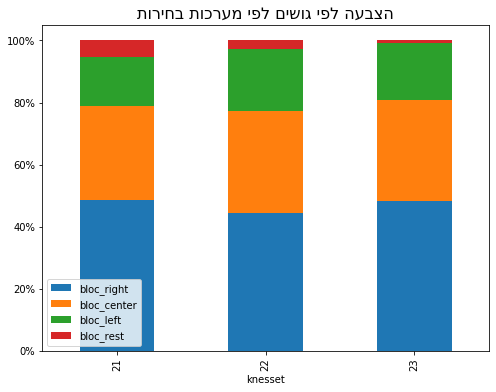

In [14]:

by_bloc_by_election_relative.drop('kosher',axis=1).plot(kind='bar',stacked='true',figsize=(8,6))
tt = 'הצבעה לפי גושים לפי מערכות בחירות'
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title(tt[::-1],fontsize=16);

## הבנת הנתונים בקובץ הישובים

כשמתחילים לעבוד עם קובץ מקובל להסתכל עליו הסתכלות כללית: מה העמודות, ולנסות להבין לפחות את העיקריות שבהן.

כאן השתמשתי בשילוב של הקואורדינטות ושל המחוז כדי להציג מפה שבה נראים בבירור המחוזות

In [15]:
cities.columns

Index(['שם יישוב', 'סמל יישוב', 'תעתיק', 'מחוז', 'נפה', 'אזור טבעי',
       'מעמד מונציפאלי', 'שיוך מטרופוליני', 'דת יישוב',
       'סך הכל אוכלוסייה 2018', 'יהודים ואחרים', 'מזה: יהודים', 'ערבים',
       'שנת ייסוד', 'צורת יישוב שוטפת', 'השתייכות ארגונית', 'קואורדינטות',
       'גובה', 'ועדת תכנון', 'מרחב משטרה', 'שנה', 'שם יישוב באנגלית',
       'אשכול רשויות מקומיות'],
      dtype='object')

In [16]:
# בלי קובץ מלווה אנחנו לא יודעים מה זה אומר
cities['אזור טבעי'].unique()

array([623., 111., 245., 311., 241., 324., 212., 611., 411., 234., 112.,
       244., 612., 294.,  nan, 622., 292., 323., 412., 614., 512., 626.,
       513., 613., 511., 621., 322., 213., 243., 624., 235., 221., 242.,
       431., 246., 422., 442., 441., 432., 421., 211., 233., 625., 222.,
       237., 236., 293., 232., 231., 321., 627., 214., 291.])

In [17]:
# זו חלוקה גיאוגרפית בעלת כ25 ערכים שונים
cities['נפה'].unique()

array([62, 11, 24, 31, 32, 21, 61, 41, 23, 29, 73, 75, 77, 52, 53, 51, 22,
       43, 42, 44, 72, 76, 25, 74, 71], dtype=int64)

In [18]:
# זו החלוקה הגיאוגרפית הגסה ביותר
cities['מחוז'].unique()

array([6, 1, 2, 3, 4, 7, 5], dtype=int64)

In [19]:
# בשלב טעינת הנתונים הגדרתי שעמודת הקוארדינטות תהיה string
# עכשיו ניתן לפצל לקואורדינטות צפון-דרום לעומת מזרח-מערב

xy = [(float(str(s)[:5]),float(str(s)[5:])) for s in cities['קואורדינטות'] if len(str(s))==10]

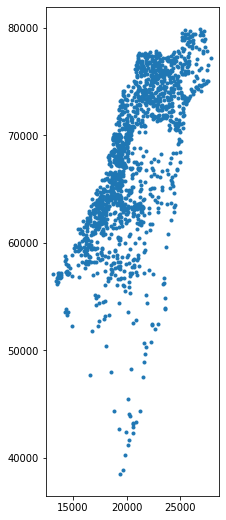

In [20]:
# כצפוי הקואורדינטות של הישובים משרטטות מפה של המדינה

plt.figure(figsize=(9,9))
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([x for x,y in xy], [y for x,y in xy],'.')

In [21]:
# עכשיו נזין את הקואורדינטות כעמודות

cities['x_coord']=cities['קואורדינטות'].apply(lambda s: float(str(s)[:5]) if len(str(s))==10 else np.nan)
cities['y_coord']=cities['קואורדינטות'].apply(lambda s: float(str(s)[5:]) if len(str(s))==10 else np.nan)

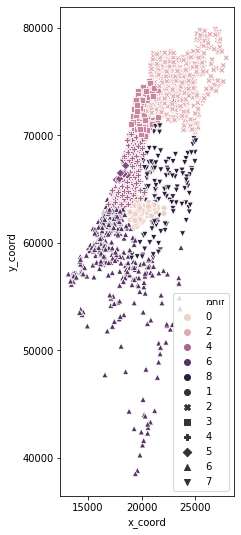

In [22]:
# בעזרת הקואורדינטות אנו משרטטים מפה של המחוזות

plt.figure(figsize=(9,9))
plt.gca().set_aspect('equal', adjustable='box')

sns.scatterplot(x='x_coord',y='y_coord',style='מחוז',hue='מחוז', data=cities)

### צירוף נתוני היישובים לקובץ של תוצאות שלוש מערכות הבחירות

In [23]:
# כמה ישובים מופיעים במערכות בחירות
len(set(knesset['סמל ישוב']))


1216

In [24]:
# כמה ישובים מופיעים בקובץ ערים
len(set(cities['סמל יישוב']))

1482

In [25]:
# קבוצת החיתוך בגודל 1213 מכאן שחסרים שלושה סמלי ישוב
len(set(knesset['סמל ישוב']) & set(cities['סמל יישוב']))

1213

In [26]:
# אלה הם החסרים
set(knesset['סמל ישוב']) - set(cities['סמל יישוב'])

{3400, 9999, 99999}

In [27]:
#עכשיו נבדוק מה הם מייצגים 

problems = knesset['סמל ישוב'].apply(lambda x: x in [3400, 9999, 99999])
knesset[problems]

,knesset,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,טב,ל,מחל,פה,שס,bloc_right,bloc_center,bloc_left,bloc_rest
1011,21,חברון,3400,285,226,0,226,1,0,0,178,1,18,6,1,197.0,7.0,1.0,21
1213,21,מעטפות חיצוניות,99999,0,240783,1961,238822,19266,8070,6988,21467,4637,78029,68702,10064,117630.0,73339.0,26254.0,21599
1011,22,חברון,3400,296,230,0,230,1,3,0,105,1,24,8,1,133.0,9.0,1.0,87
1213,22,מעטפות חיצוניות,9999,0,282442,2226,280216,27072,11649,11974,24810,14019,77953,84654,17598,132010.0,98673.0,39046.0,10487
385,23,חברון,3400,297,216,1,215,0,21,0,98,1,45,2,7,171.0,3.0,0.0,41
712,23,מעטפות חיצוניות,9999,0,330209,2507,327702,24137,13387,18077,27357,12815,107049,97828,23264,171057.0,110643.0,42214.0,3788


### תוצאות ניתוח ההפרשים ב'סמל ישוב' בין הקבצים

אנחנו רואים שלחברון אין קוד ישוב רלוונטי ברשימת הערים. זה יישוב קטן ולכן נוותר עליו

המעטפות החיצוניות הם ללא נתון בעלי זכות בחירה ולכן בכל מקרה לא ניתן לעשות עליהם ניתוח

מכאן שכשנעשה איחוד של הנתונים, שש השורות האלו ייוסרו מהטבלה

אנחנו מוכנים לוותר על האינפורמציה הזו. לחילופין צריך לחפש את חברון בקובץ הערים למקרה שהיא קיימת עם קוד אחר

In [100]:
# אלו העמודות מקובץ הערים שנשתמש בהמשך, כל השאר נזרוק
required_cols = ['שם יישוב', 'סמל יישוב', 'מחוז', 'נפה',
       'מעמד מונציפאלי', 'דת יישוב',
       'סך הכל אוכלוסייה 2018', 'מזה: יהודים', 'ערבים',
       'אזור טבעי', 'שם יישוב באנגלית',
    'צורת יישוב שוטפת']

### joining the cities and the knesset poll results

In [101]:
cj= cities[required_cols].copy()
knesset_cities = pd.merge(left = knesset,
                          right= cj,
                          left_on = 'סמל ישוב',
                          right_on = 'סמל יישוב',
                         how='inner')


In [102]:
# בדיקה שיש את העמודות כמו שציפינו
knesset_cities.columns

Index(['knesset', 'שם ישוב', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים',
       'אמת', 'ג', 'ודעם', 'טב', 'ל', 'מחל', 'פה', 'שס', 'bloc_right',
       'bloc_center', 'bloc_left', 'bloc_rest', 'שם יישוב', 'סמל יישוב',
       'מחוז', 'נפה', 'מעמד מונציפאלי', 'דת יישוב', 'סך הכל אוכלוסייה 2018',
       'מזה: יהודים', 'ערבים', 'אזור טבעי', 'שם יישוב באנגלית',
       'צורת יישוב שוטפת'],
      dtype='object')

In [31]:
knesset_cities.head().T

,0,1,2,3,4
knesset,21,22,23,21,22
שם ישוב,שחר,שחר,שחר,תירוש,תירוש
סמל ישוב,7,7,7,10,10
בזב,516,517,521,333,332
מצביעים,371,377,387,237,245
פסולים,0,0,0,2,0
כשרים,371,377,387,235,245
אמת,26,44,21,5,2
ג,2,8,6,3,4
ודעם,0,0,0,0,0


In [32]:
# התוצאה הזו מראה שאכן נפלו 6 שורות כמו שציפינו
len(knesset_cities),len(knesset)

(3636, 3642)

# סעיף 4

### Random Forest
נרצה לחזות את כמות הקולות הכשרים של יישוב ביחס לבעלי_זכות_בחירה.
נשתמש בתכונות הבאות של יישוב:
- אחוז יהודים
- צורת ישוב שוטפת
- מעמד מוניציפאלי
- מחוז


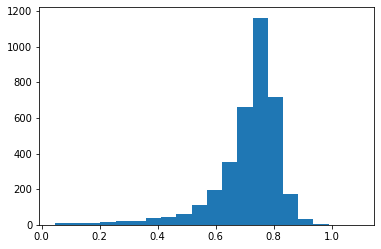

In [33]:
percent_kosher = knesset_cities['כשרים'].values / knesset_cities['בזב'].values
percent_jewish = knesset_cities['מזה: יהודים'].fillna(0).values / knesset_cities['סך הכל אוכלוסייה 2018'].fillna(1).values

plt.hist(percent_kosher,bins=20);

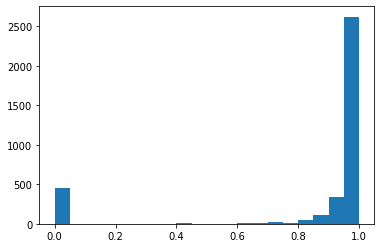

In [34]:
plt.hist(percent_jewish,bins=20);

### One Hot encoder
זה אומר למפות כל ערך של משתנה קטגורי לעמודה אחרת.

בכל שורה יהיה 1 רק במקום המתאים לערך של הקטגוריה שהיה באותה שורה

 OneHotEncoder 
 לשימחתנו יש אובייקט שמבצע את זה באופן אוטומטי

In [35]:
categorical_cols_for_rf = ['צורת יישוב שוטפת', 'מעמד מונציפאלי', 'מחוז']

categorical_onehot = OneHotEncoder(sparse=False).fit_transform(knesset_cities[categorical_cols_for_rf].fillna(0))
print(categorical_onehot.shape)


(3636, 88)


In [36]:
# יש ישובים בלי נתוני אוכלוסיה
# כדי למנוע nan
# הכנסתי בהם ערך של 1

knesset_cities[np.isnan(percent_jewish)]

,knesset,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,סמל יישוב,מחוז,נפה,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,מזה: יהודים,ערבים,צורת יישוב שוטפת,שם יישוב באנגלית


In [37]:
# הוצאת היישובים שהם test מהדאטה
# חלוקה אקראית של רשימת הישובים הנותרים לtrain, validation

In [38]:
PERCENT_VALIDATION = 0.2
test_town_codes = {77, 2600, 4000, 4100, 7500}
other_town_codes = set(knesset_cities['סמל ישוב'])-test_town_codes

np.random.seed(4477)
train_town_codes, validation_town_codes = train_test_split(np.array(list(other_town_codes)),test_size=PERCENT_VALIDATION) 

town_set = {k: 'test' if k in test_town_codes
                                    else 'valid' if k in set(validation_town_codes)
                                    else 'train' 
            for k in test_town_codes | other_town_codes}

town_set_str = knesset_cities['סמל ישוב'].apply(lambda t: town_set[t])
knesset_cities['town_set'] = town_set_str 
display(knesset_cities[town_set_str == 'test'])
display(knesset_cities[town_set_str == 'valid'].head(12))
display(knesset_cities[town_set_str == 'train'].head(12))

print(np.unique(knesset_cities['town_set'].values,return_counts=True))

,knesset,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,מחוז,נפה,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,מזה: יהודים,ערבים,צורת יישוב שוטפת,שם יישוב באנגלית,town_set
141,21,איילת השחר,77,812,595,1,594,174,3,0,...,2,21,1.0,1.0,1134.0,1082.0,NaN,330,Ayyelet HaShahar,test
142,22,איילת השחר,77,814,567,1,566,183,3,0,...,2,21,1.0,1.0,1134.0,1082.0,NaN,330,Ayyelet HaShahar,test
143,23,איילת השחר,77,818,587,2,585,124,2,2,...,2,21,1.0,1.0,1134.0,1082.0,NaN,330,Ayyelet HaShahar,test
2997,21,אילת,2600,50304,22851,168,22683,1078,103,114,...,6,62,0.0,1.0,51935.0,41906.0,2260.0,150,Elat,test
2998,22,אילת,2600,50539,22840,125,22715,1452,280,176,...,6,62,0.0,1.0,51935.0,41906.0,2260.0,150,Elat,test
2999,23,אילת,2600,50714,22754,118,22636,851,185,237,...,6,62,0.0,1.0,51935.0,41906.0,2260.0,150,Elat,test
3403,21,חיפה,4000,247866,145606,1028,144578,14919,5210,8783,...,3,31,0.0,4.0,283640.0,217360.0,32697.0,130,Haifa,test
3404,22,חיפה,4000,248570,144888,846,144042,15760,5629,12697,...,3,31,0.0,4.0,283640.0,217360.0,32697.0,130,Haifa,test
3405,23,חיפה,4000,249627,145488,863,144625,10395,5604,14915,...,3,31,0.0,4.0,283640.0,217360.0,32697.0,130,Haifa,test
3475,21,קצרין,4100,6040,3565,38,3527,142,7,1,...,2,29,99.0,1.0,7132.0,5791.0,79.0,180,Qazrin,test


,knesset,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,מחוז,נפה,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,מזה: יהודים,ערבים,צורת יישוב שוטפת,שם יישוב באנגלית,town_set
0,21,שחר,7,516,371,0,371,26,2,0,...,6,61,50.0,1.0,875.0,866.0,NaN,310,Shahar,valid
1,22,שחר,7,517,377,0,377,44,8,0,...,6,61,50.0,1.0,875.0,866.0,NaN,310,Shahar,valid
2,23,שחר,7,521,387,0,387,21,6,0,...,6,61,50.0,1.0,875.0,866.0,NaN,310,Shahar,valid
48,21,עוצם,32,426,326,2,324,1,4,0,...,6,61,50.0,1.0,642.0,639.0,3.0,310,Ozem,valid
49,22,עוצם,32,434,344,2,342,6,5,0,...,6,61,50.0,1.0,642.0,639.0,3.0,310,Ozem,valid
50,23,עוצם,32,428,364,2,362,9,6,0,...,6,61,50.0,1.0,642.0,639.0,3.0,310,Ozem,valid
51,21,בת שלמה,33,432,358,3,355,75,1,2,...,3,32,15.0,1.0,651.0,635.0,NaN,310,Bat Shelomo,valid
52,22,בת שלמה,33,435,338,0,338,90,2,1,...,3,32,15.0,1.0,651.0,635.0,NaN,310,Bat Shelomo,valid
53,23,בת שלמה,33,441,354,0,354,68,1,4,...,3,32,15.0,1.0,651.0,635.0,NaN,310,Bat Shelomo,valid
57,21,שדה דוד,36,395,299,0,299,10,2,0,...,6,61,50.0,1.0,547.0,538.0,NaN,310,Sede Dawid,valid


,knesset,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,מחוז,נפה,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,מזה: יהודים,ערבים,צורת יישוב שוטפת,שם יישוב באנגלית,town_set
3,21,תירוש,10,333,237,2,235,5,3,0,...,1,11,26.0,1.0,501.0,500.0,NaN,310,Tirosh,train
4,22,תירוש,10,332,245,0,245,2,4,0,...,1,11,26.0,1.0,501.0,500.0,NaN,310,Tirosh,train
5,23,תירוש,10,331,252,0,252,2,3,0,...,1,11,26.0,1.0,501.0,500.0,NaN,310,Tirosh,train
6,21,"ניר ח""ן",11,403,289,1,288,31,0,0,...,6,61,50.0,1.0,552.0,536.0,NaN,310,Nir Hen,train
7,22,"ניר ח""ן",11,406,287,0,287,37,1,1,...,6,61,50.0,1.0,552.0,536.0,NaN,310,Nir Hen,train
8,23,ניר חן,11,404,271,0,271,29,0,1,...,6,61,50.0,1.0,552.0,536.0,NaN,310,Nir Hen,train
9,21,חצבה,13,502,403,0,403,61,2,0,...,6,62,54.0,1.0,605.0,561.0,10.0,310,Hazeva,train
10,22,חצבה,13,502,373,0,373,56,2,0,...,6,62,54.0,1.0,605.0,561.0,10.0,310,Hazeva,train
11,23,חצבה,13,519,396,5,391,45,1,0,...,6,62,54.0,1.0,605.0,561.0,10.0,310,Hazeva,train
12,21,נועם,15,302,217,2,215,1,4,0,...,6,61,34.0,1.0,349.0,346.0,NaN,310,No'am,train


(array(['test', 'train', 'valid'], dtype=object), array([  15, 2897,  724], dtype=int64))


In [39]:
X = np.concatenate([percent_jewish[:,np.newaxis], categorical_onehot],axis=1)
Y = percent_kosher

Xtr_vd = X[:2424,:]
Ytr_vd = Y[:2424]

X_train = Xtr_vd[knesset_cities['town_set'][:2424]=='train']
y_train = Ytr_vd[knesset_cities['town_set'][:2424]=='train']

X_valid = Xtr_vd[knesset_cities['town_set'][:2424]=='valid']
y_valid = Ytr_vd[knesset_cities['town_set'][:2424]=='valid']

X_test = X[town_set_str=='test']
Y_test = Y[town_set_str=='test']

print(X.shape, Y.shape)
print(Xtr_vd.shape, Ytr_vd.shape)

#X_train, X_valid, y_train, y_valid = train_test_split(Xtr, Ytr, test_size=0.20, random_state=42)

print([a.shape for a in (X_train, X_valid, y_train, y_valid)])


(3636, 89) (3636,)
(2424, 89) (2424,)
[(1932, 89), (489, 89), (1932,), (489,)]


In [40]:
model = RandomForestRegressor(random_state=RSEED).fit(X_train,y_train)

In [41]:
yhat_valid = model.predict(X_valid)

(0.1, 1)

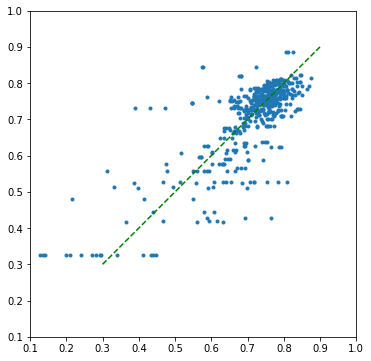

In [42]:
plt.figure(figsize=(6,6))
plt.plot(y_valid, yhat_valid,'.')
plt.plot([0.3, 0.9],[0.3, 0.9],'g--')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0.1, 1)
plt.ylim(0.1,1)

In [43]:
mean_squared_error(y_valid, yhat_valid)

0.00734992636585381

### Optimization
trying different hyperparameters of the random forest regressor

### 1. change number of estimators

In [44]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=60).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.007068242433773463

In [45]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=40).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.007283704760201917

In [46]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=80).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.007385865391190904

### 2. 60 estimators was best. now change max depth

In [47]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=60, max_depth=2).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.006646175038356626

In [48]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=60, max_depth=1).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.009309594992544485

In [49]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=60, max_depth=3).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.006039364420634037

In [50]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=60, max_depth=4).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005687813270155512

In [51]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=60, max_depth=5).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005614457148889048

In [52]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=60, max_depth=6).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005629753488391113

### 3. Max depth 5 was best. Now try to tweak n_estimators again

In [53]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=70, max_depth=5).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005708292754886819

In [54]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=50, max_depth=5).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005764460909452289

In [55]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=65, max_depth=5).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005661225527094859

### Below is the best so far

In [56]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=55, max_depth=5).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005628109661984299

In [57]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=58, max_depth=5).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005635531108076398

In [58]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=56, max_depth=5).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.00565227042273505

### 4. After tweaking, settled on n_estimators = 55
### Now change max_features

In [59]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=55, max_depth=5,min_samples_split=3).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.00560576146472153

In [60]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=55, max_depth=5,min_samples_split=3,max_features=2).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.011723139530718794

In [61]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=55, max_depth=5,min_samples_split=3,max_features=10).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.006729887520599692

In [62]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=55, max_depth=5,min_samples_split=3,max_features=15).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005635216655504465

In [63]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=55, max_depth=5,min_samples_split=3,max_features=25).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.005250453096552337

### Could not imporve with max_features. Again show best result

In [64]:
model = RandomForestRegressor(random_state=RSEED,n_estimators=55, max_depth=5,min_samples_split=3).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
mean_squared_error(y_valid,yhat_valid)

0.00560576146472153

### Predict on test

In [65]:
summary_df = knesset_cities[town_set_str == 'test']
summary_df.insert(loc=5,column='percent_kosher' ,value= Y[town_set_str == 'test'])
summary_df = summary_df[['knesset', 'שם ישוב', 'בזב', 'כשרים','percent_kosher']]

yhat_test = model.predict(X_test)
summary_df.loc[:,'predict_kosher'] = yhat_test

In [66]:


summary_df = summary_df[summary_df['knesset']==23]

display(summary_df)

,knesset,שם ישוב,בזב,כשרים,percent_kosher,predict_kosher
143,23,איילת השחר,818,585,0.715159,0.712196
2999,23,אילת,50714,22636,0.446346,0.587948
3405,23,חיפה,249627,144625,0.579364,0.538695
3477,23,קצרין,6175,3498,0.566478,0.616380
3567,23,סחנין,21624,17085,0.790094,0.576323


# סעיף 3 : CLUSTERING
## ראינו למעלה בגרף של " הצבעה של גושים לפי מערכות בחירות" שאין ממש הבדל בין הנתונים ב שלושת הבחירות אז בחרנו לעשות CLUSTERING רק על בחירות ה 23

### טעינת + איחוד הנתונים

In [67]:
CITY_NAME_COLUMN = "שם ישוב"
votes_data = pd.read_csv("C:\\Users\\HP\\Downloads\\votes23.csv", encoding="ISO-8859-8")
votes_data = votes_data.sort_values(by="שם ישוב")
votes_data.rename({"שם ישוב": CITY_NAME_COLUMN}, axis=1, inplace=True)
cities_data = pd.read_excel("C:\\Users\\HP\\Downloads\\cities.xlsx")
cities_data = cities_data.sort_values(by="שם יישוב")
cities_data.rename({"שם יישוב": CITY_NAME_COLUMN}, axis=1, inplace=True)

In [68]:
parties = ["אמת", "ג", "ודעם", "שס", "פה", "מחל", "טב", "ל"]
properties = ["סמל ועדה", CITY_NAME_COLUMN, "סמל ישוב", "בזב", "מצביעים", "פסולים", "כשרים"]
columns_to_keep = properties + parties
votes_data = votes_data[columns_to_keep]
#votes_data[parties] = votes_data[parties].div(votes_data["כשרים"], axis=0) # normalize to distribution 
common_cities = set(votes_data[CITY_NAME_COLUMN]) & set(cities_data[CITY_NAME_COLUMN])
data = pd.merge(left=votes_data,  right=cities_data, on=CITY_NAME_COLUMN)

In [69]:
data.head()

,סמל ועדה,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,שנת ייסוד,צורת יישוב שוטפת,השתייכות ארגונית,קואורדינטות,גובה,ועדת תכנון,מרחב משטרה,שנה,שם יישוב באנגלית,אשכול רשויות מקומיות
0,2,אבו גוש,472,4821,2718,36,2682,75,4,2157,...,NaN,280,NaN,2.105263e+09,598.0,152.0,10002475.0,2018,Abu Ghosh,NaN
1,6,אבו סנאן,473,9422,6090,53,6037,92,6,4458,...,NaN,270,NaN,2.160776e+09,19.0,252.0,10004315.0,2018,Abu Sinan,NaN
2,18,אבו תלול,1375,943,576,2,574,0,0,565,...,NaN,450,NaN,1.933457e+09,340.0,624.0,15003711.0,2018,Abu Tulul,610.0
3,8,אבטין,652,1818,1161,10,1151,4,0,1110,...,NaN,290,NaN,2.108874e+09,19.0,301.0,10004207.0,2018,Ibtin,NaN
4,6,אבטליון,1275,308,233,0,233,35,0,7,...,1987,370,10.0,2.331475e+09,308.0,205.0,10004513.0,2018,Avtalyon,210.0


In [70]:
data2=data.copy()
data2[parties] = data[parties].div(data["כשרים"], axis=0)
data2.head()

,סמל ועדה,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,שנת ייסוד,צורת יישוב שוטפת,השתייכות ארגונית,קואורדינטות,גובה,ועדת תכנון,מרחב משטרה,שנה,שם יישוב באנגלית,אשכול רשויות מקומיות
0,2,אבו גוש,472,4821,2718,36,2682,0.027964,0.001491,0.804251,...,NaN,280,NaN,2.105263e+09,598.0,152.0,10002475.0,2018,Abu Ghosh,NaN
1,6,אבו סנאן,473,9422,6090,53,6037,0.015239,0.000994,0.738446,...,NaN,270,NaN,2.160776e+09,19.0,252.0,10004315.0,2018,Abu Sinan,NaN
2,18,אבו תלול,1375,943,576,2,574,0.000000,0.000000,0.984321,...,NaN,450,NaN,1.933457e+09,340.0,624.0,15003711.0,2018,Abu Tulul,610.0
3,8,אבטין,652,1818,1161,10,1151,0.003475,0.000000,0.964379,...,NaN,290,NaN,2.108874e+09,19.0,301.0,10004207.0,2018,Ibtin,NaN
4,6,אבטליון,1275,308,233,0,233,0.150215,0.000000,0.030043,...,1987,370,10.0,2.331475e+09,308.0,205.0,10004513.0,2018,Avtalyon,210.0


# K MEANS

In [71]:
k_values = np.arange(1, 11, 1)
mean_distance_to_center = np.zeros(len(k_values))
for i in range(len(k_values)):
    cls = KMeans(n_clusters=k_values[i], random_state=RSEED).fit(X=data2[parties].values)
    data2.insert(data2.shape[1], "cluster"+str(k_values[i]), cls.labels_, True)
    mean_distance_to_center[i] = cls.inertia_ # see KMeans docu

# Cluster 2 = Arabs cities/villages

In [72]:
data2.head()

,סמל ועדה,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10
0,2,אבו גוש,472,4821,2718,36,2682,0.027964,0.001491,0.804251,...,0,0,1,1,2,2,2,2,2,1
1,6,אבו סנאן,473,9422,6090,53,6037,0.015239,0.000994,0.738446,...,0,0,1,1,2,2,2,2,2,1
2,18,אבו תלול,1375,943,576,2,574,0.000000,0.000000,0.984321,...,0,0,1,1,2,2,2,2,2,1
3,8,אבטין,652,1818,1161,10,1151,0.003475,0.000000,0.964379,...,0,0,1,1,2,2,2,2,2,1
4,6,אבטליון,1275,308,233,0,233,0.150215,0.000000,0.030043,...,0,1,0,0,1,1,1,1,4,0


In [73]:
data2.columns

Index(['סמל ועדה', 'שם ישוב', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים',
       'אמת', 'ג', 'ודעם', 'שס', 'פה', 'מחל', 'טב', 'ל', 'סמל יישוב', 'תעתיק',
       'מחוז', 'נפה', 'אזור טבעי', 'מעמד מונציפאלי', 'שיוך מטרופוליני',
       'דת יישוב', 'סך הכל אוכלוסייה 2018', 'יהודים ואחרים', 'מזה: יהודים',
       'ערבים', 'שנת ייסוד', 'צורת יישוב שוטפת', 'השתייכות ארגונית',
       'קואורדינטות', 'גובה', 'ועדת תכנון', 'מרחב משטרה', 'שנה',
       'שם יישוב באנגלית', 'אשכול רשויות מקומיות', 'cluster1', 'cluster2',
       'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8',
       'cluster9', 'cluster10'],
      dtype='object')

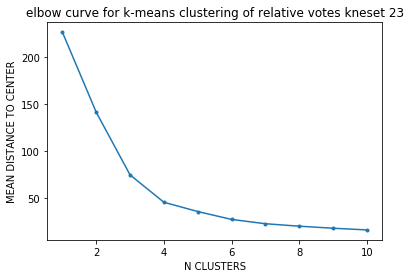

In [74]:
plt.figure()
plt.title(f"elbow curve for k-means clustering of relative votes kneset 23")
plt.xlabel("N CLUSTERS")
plt.ylabel("MEAN DISTANCE TO CENTER")
plt.plot(k_values, mean_distance_to_center, ".-")
plt.show()

# אפשר לראות ש עד 5 CLUSTERS זה עובד מצויין ו מ CLUSTER 6 ומעלה זה לא משפר כלום

In [75]:
cls = KMeans(n_clusters=5,random_state=RSEED).fit(X=data2[parties].values)

In [76]:
clsuters = cls.predict(data2[parties])

In [77]:
len(clsuters)

1043

In [78]:
np.unique(clsuters,return_counts=True)

(array([0, 1, 2, 3, 4]), array([296, 526,  74, 125,  22], dtype=int64))

In [79]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(data2[parties],clsuters) #The minimum score is zero, with lower values indicating better clustering.

0.5987655303198242

In [80]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(data2[parties],np.hstack([clsuters[:500],clsuters[500:]+1]))

1.99216525022907

In [81]:
print(np.array2string(cls.cluster_centers_, precision=2, suppress_small=True))


[[0.04 0.02 0.01 0.1  0.19 0.53 0.07 0.03]
 [0.2  0.   0.01 0.01 0.58 0.14 0.03 0.03]
 [0.03 0.   0.9  0.01 0.03 0.01 0.   0.01]
 [0.01 0.04 0.   0.03 0.06 0.26 0.56 0.01]
 [0.   0.55 0.   0.23 0.01 0.11 0.08 0.  ]]


In [82]:
df = pd.DataFrame(columns=parties, data=cls.cluster_centers_)
df

,אמת,ג,ודעם,שס,פה,מחל,טב,ל
0,0.041084,0.020574,0.007058,0.102474,0.192651,0.525563,0.066810,0.032309
1,0.196733,0.003014,0.009856,0.007327,0.578323,0.144722,0.028143,0.026310
2,0.028862,0.000505,0.904598,0.007225,0.034934,0.010442,0.000840,0.006748
3,0.011736,0.035677,0.000559,0.032164,0.061407,0.262927,0.561663,0.006137
4,0.002669,0.547262,0.000427,0.227592,0.011764,0.107017,0.084520,0.002264


In [83]:
data2.columns

Index(['סמל ועדה', 'שם ישוב', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים',
       'אמת', 'ג', 'ודעם', 'שס', 'פה', 'מחל', 'טב', 'ל', 'סמל יישוב', 'תעתיק',
       'מחוז', 'נפה', 'אזור טבעי', 'מעמד מונציפאלי', 'שיוך מטרופוליני',
       'דת יישוב', 'סך הכל אוכלוסייה 2018', 'יהודים ואחרים', 'מזה: יהודים',
       'ערבים', 'שנת ייסוד', 'צורת יישוב שוטפת', 'השתייכות ארגונית',
       'קואורדינטות', 'גובה', 'ועדת תכנון', 'מרחב משטרה', 'שנה',
       'שם יישוב באנגלית', 'אשכול רשויות מקומיות', 'cluster1', 'cluster2',
       'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8',
       'cluster9', 'cluster10'],
      dtype='object')

In [84]:
data2[data2.cluster5==2] 

,סמל ועדה,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10
0,2,אבו גוש,472,4821,2718,36,2682,0.027964,0.001491,0.804251,...,0,0,1,1,2,2,2,2,2,1
1,6,אבו סנאן,473,9422,6090,53,6037,0.015239,0.000994,0.738446,...,0,0,1,1,2,2,2,2,2,1
2,18,אבו תלול,1375,943,576,2,574,0.000000,0.000000,0.984321,...,0,0,1,1,2,2,2,2,2,1
3,8,אבטין,652,1818,1161,10,1151,0.003475,0.000000,0.964379,...,0,0,1,1,2,2,2,2,2,1
26,18,אום בטין,1358,2011,1158,8,1150,0.002609,0.000000,0.978261,...,0,0,1,1,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,5,רומת הייב,997,1368,651,3,648,0.228395,0.000000,0.575617,...,0,0,1,1,2,2,2,2,2,1
916,5,ריינה,542,11436,7764,58,7706,0.007916,0.000389,0.970023,...,0,0,1,1,2,2,2,2,2,1
997,6,שעב,538,4868,3800,13,3787,0.002641,0.001056,0.980459,...,0,0,1,1,2,2,2,2,2,1
1008,6,שפרעם,8800,29120,19200,168,19032,0.012978,0.000210,0.830969,...,0,0,1,1,2,2,2,2,2,1


In [85]:
data2.columns

Index(['סמל ועדה', 'שם ישוב', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים',
       'אמת', 'ג', 'ודעם', 'שס', 'פה', 'מחל', 'טב', 'ל', 'סמל יישוב', 'תעתיק',
       'מחוז', 'נפה', 'אזור טבעי', 'מעמד מונציפאלי', 'שיוך מטרופוליני',
       'דת יישוב', 'סך הכל אוכלוסייה 2018', 'יהודים ואחרים', 'מזה: יהודים',
       'ערבים', 'שנת ייסוד', 'צורת יישוב שוטפת', 'השתייכות ארגונית',
       'קואורדינטות', 'גובה', 'ועדת תכנון', 'מרחב משטרה', 'שנה',
       'שם יישוב באנגלית', 'אשכול רשויות מקומיות', 'cluster1', 'cluster2',
       'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8',
       'cluster9', 'cluster10'],
      dtype='object')

# GMM

In [ ]:


data2=data2.iloc[:,:47]
k_values=np.arange(1, 21, 1)
cluster_means =[]
for i in range(len(k_values)):
    cls = GaussianMixture(n_components=k_values[i], random_state=RSEED).fit(X=data2[parties].values)
#cls.predict(data2[parties].values)
    data2.insert(data2.shape[1], "GMM"+str(k_values[i]), cls.predict(data2[parties].values), True)
    cluster_means.append(cls.means_)
    

cls.means_

In [88]:
Y = GaussianMixture(n_components=9, random_state=RSEED).fit_predict(X=data2[parties].values)

In [89]:
np.unique(Y,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([305,  74,  40,  99,  52,  55, 227,  50, 141], dtype=int64))

In [90]:
davies_bouldin_score(data2[parties],Y)

2.0953618145296726

In [91]:
for j in range (1,21) :
    gmmcol = "GMM"+str(j)
    distcol = "dist"+str(j)
    data2[distcol]=0
    values=[]
    for i in range (data2.shape[0]):  
      center=cluster_means[j-1][data2[gmmcol][i],:]
      coordinate=data2[parties].iloc[i,:].values
      values.append(sum((coordinate-center)**2))
    data2[distcol]=values
   

In [92]:
dist = ["dist"+str(j) for j in range(1,21)]
GMMDistanceToCenter=data2[dist].mean(axis=0)

In [93]:
data2["dist9"].head()

0    0.019048
1    0.038389
2    0.008241
3    0.004678
4    0.024684
Name: dist9, dtype: float64

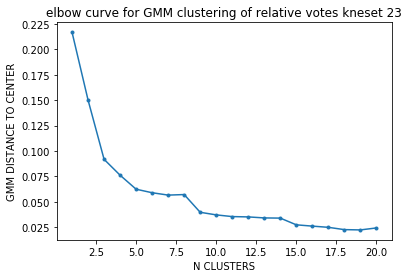

In [94]:
plt.figure()
plt.title(f"elbow curve for GMM clustering of relative votes kneset 23")
plt.xlabel("N CLUSTERS")
plt.ylabel("GMM DISTANCE TO CENTER")
plt.plot(k_values, GMMDistanceToCenter, ".-")
plt.show()

# Adaboost - סעיף 5
* נתוני קלט: השורות משתי הבחירות הראשונות של כל היישובים למעט היישובים  ירושלים, בני ברק, סכנין, כרמיאל, ודאלית אל כרמל
* נשתמש באותן תכונות של הערים כמו ב random forest

In [95]:
sum(knesset_cities['שם ישוב'].map(lambda x: [x] if x.startswith('דאל') else []),[])

['דאלית אל-כרמל', 'דאלית אל-כרמל', 'דאלית אלכרמל']

In [96]:
city_codes = dict(zip(knesset_cities['שם ישוב'],knesset_cities['סמל ישוב']))
for town in  'ירושלים, בני ברק, סחנין, כרמיאל, דאלית אל-כרמל'.replace(', ',',').split(','):
    print(town, city_codes[town])

ירושלים 3000
בני ברק 6100
סחנין 7500
כרמיאל 1139
דאלית אל-כרמל 494


In [97]:
percent_likud = knesset_cities['מחל'].values /  knesset_cities['כשרים'].values
percent_kahol_lavan = knesset_cities['פה'].values /  knesset_cities['כשרים'].values
percent_arab = knesset_cities['ודעם'].values /  knesset_cities['כשרים'].values

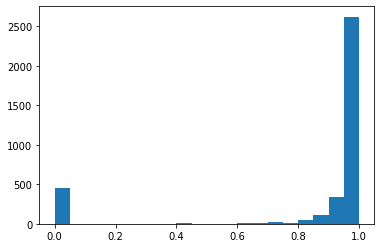

In [98]:
percent_jewish = knesset_cities['מזה: יהודים'].fillna(0).values / knesset_cities['סך הכל אוכלוסייה 2018'].fillna(1).values
plt.hist(percent_jewish,bins=20);

In [103]:
categorical_cols_for_rf = ['צורת יישוב שוטפת', 'מעמד מונציפאלי', 'מחוז','אזור טבעי','דת יישוב']

categorical_onehot = OneHotEncoder(sparse=False).fit_transform(knesset_cities[categorical_cols_for_rf].fillna(0))
print(categorical_onehot.shape)


(3636, 146)


In [104]:
# יש ישובים בלי נתוני אוכלוסיה
# כדי למנוע nan
# הכנסתי בהם ערך של 1

knesset_cities[np.isnan(percent_jewish)]

,knesset,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,מחוז,נפה,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,מזה: יהודים,ערבים,אזור טבעי,שם יישוב באנגלית,צורת יישוב שוטפת


In [105]:
# הוצאת היישובים שהם test מהדאטה
# חלוקה אקראית של רשימת הישובים הנותרים לtrain, validation

In [145]:
PERCENT_VALIDATION = 0.2
test_town_codes = {3000, 6100, 7500, 1139, 494}
other_town_codes = set(knesset_cities['סמל ישוב'])-test_town_codes

np.random.seed(4477)
train_town_codes, validation_town_codes = train_test_split(np.array(list(other_town_codes)),test_size=PERCENT_VALIDATION) 

town_set = {k: 'test' if k in test_town_codes
                                    else 'valid' if k in set(validation_town_codes)
                                    else 'train' 
            for k in test_town_codes | other_town_codes}

town_set_str = knesset_cities['סמל ישוב'].apply(lambda t: town_set[t])
knesset_cities['town_set'] = town_set_str 
display(knesset_cities[town_set_str == 'test'])
display(knesset_cities[town_set_str == 'valid'].head(12))
display(knesset_cities[town_set_str == 'train'].head(12))

print(np.unique(knesset_cities['town_set'].values,return_counts=True))

,knesset,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,נפה,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,מזה: יהודים,ערבים,אזור טבעי,שם יישוב באנגלית,צורת יישוב שוטפת,town_set
1050,21,דאלית אל-כרמל,494,12488,7464,60,7404,760,1,152,...,31,99.0,2.0,17427.0,33.0,17382.0,311.0,Daliyat Al-Karmel,270,test
1051,22,דאלית אל-כרמל,494,12579,7463,47,7416,629,3,333,...,31,99.0,2.0,17427.0,33.0,17382.0,311.0,Daliyat Al-Karmel,270,test
1052,23,דאלית אלכרמל,494,12693,7150,48,7102,481,1,650,...,31,99.0,2.0,17427.0,33.0,17382.0,311.0,Daliyat Al-Karmel,270,test
2271,21,כרמיאל,1139,41234,24970,259,24711,1213,695,232,...,24,0.0,1.0,46124.0,37330.0,1507.0,242.0,Karmi'el,160,test
2272,22,כרמיאל,1139,41395,24549,233,24316,1398,780,348,...,24,0.0,1.0,46124.0,37330.0,1507.0,242.0,Karmi'el,160,test
2273,23,כרמיאל,1139,41328,24537,167,24370,822,807,468,...,24,0.0,1.0,46124.0,37330.0,1507.0,242.0,Karmi'el,160,test
3030,21,ירושלים,3000,410258,262103,2054,260049,16194,60632,2147,...,11,0.0,4.0,919438.0,555845.0,349572.0,111.0,Jerusalem,120,test
3031,22,ירושלים,3000,413140,261817,1840,259977,18237,64937,3582,...,11,0.0,4.0,919438.0,555845.0,349572.0,111.0,Jerusalem,120,test
3032,23,ירושלים,3000,415991,263214,1625,261589,12919,63782,5321,...,11,0.0,4.0,919438.0,555845.0,349572.0,111.0,Jerusalem,120,test
3523,21,בני ברק,6100,109000,84202,1398,82804,318,51178,16,...,52,0.0,1.0,198863.0,197439.0,64.0,512.0,Bene Beraq,140,test


,knesset,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,נפה,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,מזה: יהודים,ערבים,אזור טבעי,שם יישוב באנגלית,צורת יישוב שוטפת,town_set
45,21,אופקים,31,20939,13715,158,13557,215,2165,3,...,62,0.0,1.0,29021.0,26936.0,201.0,622.0,Ofaqim,160,valid
46,22,אופקים,31,21413,14236,134,14102,541,2202,12,...,62,0.0,1.0,29021.0,26936.0,201.0,622.0,Ofaqim,160,valid
47,23,אופקים,31,21810,14655,109,14546,243,2198,18,...,62,0.0,1.0,29021.0,26936.0,201.0,622.0,Ofaqim,160,valid
48,21,עוצם,32,426,326,2,324,1,4,0,...,61,50.0,1.0,642.0,639.0,3.0,612.0,Ozem,310,valid
49,22,עוצם,32,434,344,2,342,6,5,0,...,61,50.0,1.0,642.0,639.0,3.0,612.0,Ozem,310,valid
50,23,עוצם,32,428,364,2,362,9,6,0,...,61,50.0,1.0,642.0,639.0,3.0,612.0,Ozem,310,valid
54,21,גדות,35,374,248,2,246,104,0,1,...,21,1.0,1.0,441.0,390.0,NaN,213.0,Gadot,330,valid
55,22,גדות,35,371,242,1,241,79,0,1,...,21,1.0,1.0,441.0,390.0,NaN,213.0,Gadot,330,valid
56,23,גדות,35,368,242,0,242,78,0,0,...,21,1.0,1.0,441.0,390.0,NaN,213.0,Gadot,330,valid
57,21,שדה דוד,36,395,299,0,299,10,2,0,...,61,50.0,1.0,547.0,538.0,NaN,612.0,Sede Dawid,310,valid


,knesset,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,...,נפה,מעמד מונציפאלי,דת יישוב,סך הכל אוכלוסייה 2018,מזה: יהודים,ערבים,אזור טבעי,שם יישוב באנגלית,צורת יישוב שוטפת,town_set
0,21,שחר,7,516,371,0,371,26,2,0,...,61,50.0,1.0,875.0,866.0,NaN,612.0,Shahar,310,train
1,22,שחר,7,517,377,0,377,44,8,0,...,61,50.0,1.0,875.0,866.0,NaN,612.0,Shahar,310,train
2,23,שחר,7,521,387,0,387,21,6,0,...,61,50.0,1.0,875.0,866.0,NaN,612.0,Shahar,310,train
3,21,תירוש,10,333,237,2,235,5,3,0,...,11,26.0,1.0,501.0,500.0,NaN,112.0,Tirosh,310,train
4,22,תירוש,10,332,245,0,245,2,4,0,...,11,26.0,1.0,501.0,500.0,NaN,112.0,Tirosh,310,train
5,23,תירוש,10,331,252,0,252,2,3,0,...,11,26.0,1.0,501.0,500.0,NaN,112.0,Tirosh,310,train
6,21,"ניר ח""ן",11,403,289,1,288,31,0,0,...,61,50.0,1.0,552.0,536.0,NaN,612.0,Nir Hen,310,train
7,22,"ניר ח""ן",11,406,287,0,287,37,1,1,...,61,50.0,1.0,552.0,536.0,NaN,612.0,Nir Hen,310,train
8,23,ניר חן,11,404,271,0,271,29,0,1,...,61,50.0,1.0,552.0,536.0,NaN,612.0,Nir Hen,310,train
9,21,חצבה,13,502,403,0,403,61,2,0,...,62,54.0,1.0,605.0,561.0,10.0,625.0,Hazeva,310,train


(array(['test', 'train', 'valid'], dtype=object), array([  15, 2895,  726], dtype=int64))


In [107]:
X = np.concatenate([percent_jewish[:,np.newaxis], categorical_onehot],axis=1)


Xtr_vd = X[:2424,:]
X_train = Xtr_vd[knesset_cities['town_set'][:2424]=='train']
X_valid = Xtr_vd[knesset_cities['town_set'][:2424]=='valid']
X_test = X[town_set_str=='test']

### Fit and optimize - Likud

In [146]:
Y = percent_likud
Ytr_vd = Y[:2424]
y_train = Ytr_vd[knesset_cities['town_set'][:2424]=='train']
y_valid = Ytr_vd[knesset_cities['town_set'][:2424]=='valid']
Y_test = Y[town_set_str=='test']

print(X.shape, Y.shape)
print(Xtr_vd.shape, Ytr_vd.shape)

#X_train, X_valid, y_train, y_valid = train_test_split(Xtr, Ytr, test_size=0.20, random_state=42)

print([a.shape for a in (X_train, X_valid, y_train, y_valid)])


(3636, 147) (3636,)
(2424, 147) (2424,)
[(1941, 147), (477, 147), (1941,), (477,)]


In [111]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor

model = AdaBoostRegressor(random_state=RSEED).fit(X_train,y_train)

In [112]:
yhat_valid = model.predict(X_valid)

(0.1, 1)

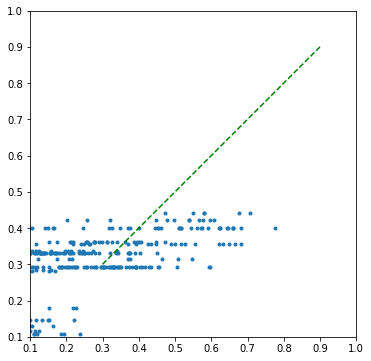

In [113]:
plt.figure(figsize=(6,6))
plt.plot(y_valid, yhat_valid,'.')
plt.plot([0.3, 0.9],[0.3, 0.9],'g--')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0.1, 1)
plt.ylim(0.1,1)

In [114]:
np.sqrt(mean_squared_error(y_valid, yhat_valid))

0.1309369732972879

### Optimization
trying different hyperparameters of the adaboost regressor

### 1. change number of estimators

In [115]:
model = AdaBoostRegressor(random_state=RSEED,n_estimators=80).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.1309369732972879

In [116]:
model = AdaBoostRegressor(random_state=RSEED,n_estimators=5).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.13164888432540803

In [117]:
model = AdaBoostRegressor(random_state=RSEED,n_estimators=1800).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.1309369732972879

no change in performance for a wide range of n_estimators.

### 2. change learning rate 

In [118]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.01).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.13692203416822193

In [119]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.02).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))


0.13428026973183568

In [120]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.03).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.13538819839520147

In [121]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=0.99).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.14079433618191667

#### performance on validation set not stable - no optimization possible

In [150]:
model_likud = AdaBoostRegressor(random_state=RSEED).fit(np.vstack([X_train, X_valid]),np.concatenate([y_train,y_valid]))


### Fit and optimize - Kahol Lavan

In [152]:
Y = percent_kahol_lavan
Ytr_vd = Y[:2424]
y_train = Ytr_vd[knesset_cities['town_set'][:2424]=='train']
y_valid = Ytr_vd[knesset_cities['town_set'][:2424]=='valid']
Y_test = Y[town_set_str=='test']

print(X.shape, Y.shape)
print(Xtr_vd.shape, Ytr_vd.shape)

#X_train, X_valid, y_train, y_valid = train_test_split(Xtr, Ytr, test_size=0.20, random_state=42)

print([a.shape for a in (X_train, X_valid, y_train, y_valid)])

(3636, 147) (3636,)
(2424, 147) (2424,)
[(1941, 147), (477, 147), (1941,), (477,)]


In [124]:
model = AdaBoostRegressor(random_state=RSEED).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.1708876861795306

In [125]:
model = AdaBoostRegressor(random_state=RSEED,n_estimators=80).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.1708876861795306

In [126]:
model = AdaBoostRegressor(random_state=RSEED,n_estimators=40).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.1708876861795306

In [127]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.01).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.17260117345105114

In [128]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.02).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.17495564598377053

In [129]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.05).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.17536527164677632

In [154]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.04).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
# this is the best found, keep it
model_kahol_lavan = AdaBoostRegressor(random_state=RSEED,learning_rate=1.04).fit(np.vstack([X_train, X_valid]),np.concatenate([y_train,y_valid]))

np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.17570363640394385

In [131]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.03).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.1733636096856558

### Build and optimize model for the joint list

In [155]:
Y = percent_arab
Ytr_vd = Y[:2424]
y_train = Ytr_vd[knesset_cities['town_set'][:2424]=='train']
y_valid = Ytr_vd[knesset_cities['town_set'][:2424]=='valid']
Y_test = Y[town_set_str=='test']

print(X.shape, Y.shape)
print(Xtr_vd.shape, Ytr_vd.shape)

#X_train, X_valid, y_train, y_valid = train_test_split(Xtr, Ytr, test_size=0.20, random_state=42)

print([a.shape for a in (X_train, X_valid, y_train, y_valid)])

(3636, 147) (3636,)
(2424, 147) (2424,)
[(1941, 147), (477, 147), (1941,), (477,)]


In [133]:
model = AdaBoostRegressor(random_state=RSEED).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.11746042491613289

In [134]:
model = AdaBoostRegressor(random_state=RSEED,n_estimators=100).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.11746042491613289

In [135]:
model = AdaBoostRegressor(random_state=RSEED,n_estimators=20).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.1192340053164133

In [136]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.01).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.11169677236345694

In [137]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.02).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.1105720238842855

In [156]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.03).fit(X_train,y_train)
# best model found, keep it
model_joint = AdaBoostRegressor(random_state=RSEED,learning_rate=1.03).fit(np.vstack([X_train,X_valid]),np.concatenate([y_train,y_valid]))
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.10960167631009102

In [139]:
model = AdaBoostRegressor(random_state=RSEED,learning_rate=1.04).fit(X_train,y_train)
yhat_valid = model.predict(X_valid)
np.sqrt(mean_squared_error(y_valid,yhat_valid))

0.11461220822343517

In [144]:
test_rows = np.logical_and(town_set_str == 'test', knesset_cities['knesset']==23)
test_df = knesset_cities[test_rows]
Xtest = X[test_rows,:]

test_df = test_df[['שם ישוב','כשרים','מחל','פה','ודעם']].reset_index(drop=True)
display(test_df)

kosher = test_df['כשרים'].values
test_df['מחל'] /= kosher
test_df['פה'] /= kosher
test_df['ודעם'] /= kosher

display(test_df.applymap(lambda x: "{:.1%}".format(x) if type(x)==float else x))


,שם ישוב,כשרים,מחל,פה,ודעם
0,דאלית אלכרמל,7102,407,5200,650
1,כרמיאל,24370,8879,6627,468
2,ירושלים,261589,72601,32800,5321
3,בני ברק,84846,4951,1133,22
4,סחנין,17085,39,120,16610


,שם ישוב,כשרים,מחל,פה,ודעם
0,דאלית אלכרמל,7102,5.7%,73.2%,9.2%
1,כרמיאל,24370,36.4%,27.2%,1.9%
2,ירושלים,261589,27.8%,12.5%,2.0%
3,בני ברק,84846,5.8%,1.3%,0.0%
4,סחנין,17085,0.2%,0.7%,97.2%


In [157]:
Y_likud = model_likud.predict(Xtest)
Y_kahol_lavan = model_kahol_lavan.predict(Xtest)
Y_joint_list = model_joint.predict(Xtest)


In [158]:
test_m = test_df.melt(id_vars = 'שם ישוב', value_vars=['מחל','פה','ודעם'],value_name="relative_vote",var_name='מפלגה')
test_m['model_vote'] = np.concatenate([Y_likud,Y_kahol_lavan,Y_joint_list])
test_m.applymap(lambda x: "{:.1%}".format(x) if type(x)==float else x )

,שם ישוב,מפלגה,relative_vote,model_vote
0,דאלית אלכרמל,מחל,5.7%,3.3%
1,כרמיאל,מחל,36.4%,31.6%
2,ירושלים,מחל,27.8%,28.6%
3,בני ברק,מחל,5.8%,28.6%
4,סחנין,מחל,0.2%,3.3%
5,דאלית אלכרמל,פה,73.2%,13.7%
6,כרמיאל,פה,27.2%,39.0%
7,ירושלים,פה,12.5%,18.4%
8,בני ברק,פה,1.3%,39.0%
9,סחנין,פה,0.7%,10.9%


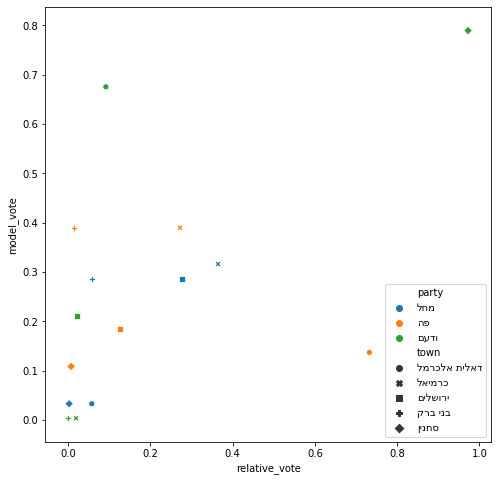

In [160]:
plt.figure(figsize=(8,8))
test_m['town'] = test_m['שם ישוב'].apply(lambda s: s[::-1])
test_m['party'] = test_m['מפלגה'].apply(lambda s: s[::-1])

sns.scatterplot(x="relative_vote",y="model_vote",data=test_m,style='town',hue='party')

# סעיף 6 - CONFUSION MATRIX


###### נתקלנו בבאג אז נאלצנו לשנות את הקבצים מ csv ל xlsx ולטעון אותם מחדש

In [171]:
Station21 = pd.read_excel(r"C:\Users\HP\Downloads\ByStation21.xlsx")
Station22 = pd.read_excel(r"C:\Users\HP\Downloads\ByStation22.xlsx")
Station23 = pd.read_excel(r"C:\Users\HP\Downloads\ByStation23.xlsx")
knesset21 = Station21[['סמל ישוב','מספר קלפי','מצביעים','פסולים']]
knesset22 = Station22[['סמל ישוב','קלפי','מצביעים','פסולים']]
knesset23 = Station23[['סמל ישוב','קלפי','מצביעים','פסולים']]


# calculate the Average Votes for every station
averageVotes = % Disqualified votes from the sum of votes

HigherOrLowerFromAverage = An value that gives an estimate of the average of votes relative to the overall average

In [172]:
knesset21['averageVotes'] = knesset21['פסולים']/ knesset21['מצביעים']
average21 = knesset21['averageVotes'].mean()
knesset21['HigherOrLowerFromAverage'] =np.where(knesset21['averageVotes'] > average21, 1,0)

knesset22['averageVotes'] = knesset22['פסולים']/knesset22['מצביעים']
average22 = knesset22['averageVotes'].mean()
knesset22['HigherOrLowerFromAverage'] =np.where(knesset22['averageVotes'] > average22, 1,0)

knesset23['averageVotes'] = knesset23['פסולים']/knesset23['מצביעים']
average23 = knesset23['averageVotes'].mean()
knesset23['HigherOrLowerFromAverage'] =np.where(knesset23['averageVotes'] > average23, 1,0)

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

# split data into train, test set

In [173]:
features = pd.concat([knesset21.drop('HigherOrLowerFromAverage', axis=1), knesset22.drop('HigherOrLowerFromAverage',axis=1)
                      ,knesset23.drop('HigherOrLowerFromAverage', axis=1)], axis =0)
labels = pd.concat([knesset21['HigherOrLowerFromAverage'], knesset22['HigherOrLowerFromAverage'],
                    knesset23['HigherOrLowerFromAverage']], axis=0)


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=RSEED)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

# DecisionTreeClassifier

In [174]:
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(X_train, y_train)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 629 nodes with maximum depth 33.


# Test set Predict

In [175]:
train_probs = tree.predict_proba(X_train)[:, 1]
probs = tree.predict_proba(X_test)[:, 1]

train_predictions = tree.predict(X_train)
predictions = tree.predict(X_test)

# check the Accuracy value of Train/Test sets

In [176]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.9999999605321958
Test ROC AUC  Score: 0.9162011173184357


# confuxion matrix function

In [184]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlim(-0.5, len(np.unique(y_test))- 0.5)
    plt.ylim( len(np.unique(predictions))- 0.5, -0.5)
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix buliding

Confusion matrix, without normalization
[[6722    0]
 [ 690 3427]]


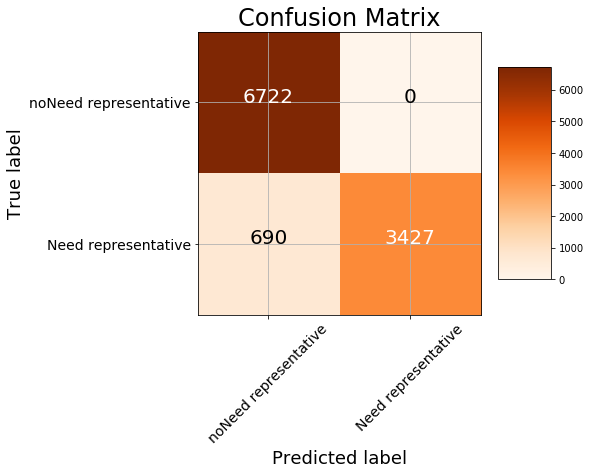

In [185]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes=['noNeed representative', 'Need representative'] ,
                      title = 'Confusion Matrix')
plt.show()

# Another Classifier - RandomForest

In [188]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1234, verbose=1,
                       warm_start=False)

# checking model data

In [189]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 600
Average maximum depth 25


# Test set Predict - new model

In [190]:
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


# Confusion matrix reBuliding

Confusion matrix, without normalization
[[6656   66]
 [ 162 3955]]


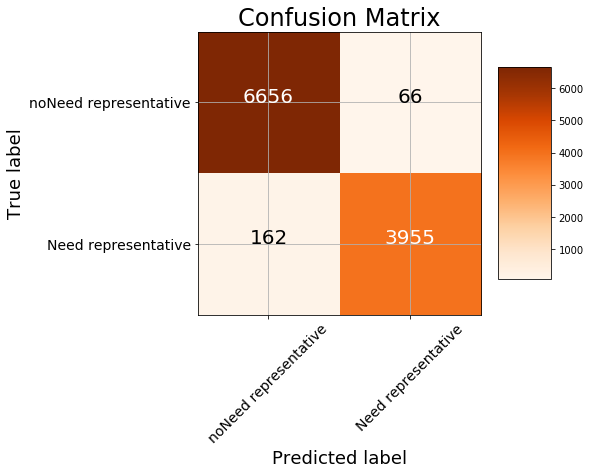

In [191]:
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm,classes=['noNeed representative', 'Need representative'] ,
                      title = 'Confusion Matrix')